In [1]:
import os
from PIL import Image
import imagehash
from tqdm import tqdm
import shutil
import zipfile

In [48]:
BASE_DIR = "/kaggle/input/brisc2025/brisc2025/segmentation_task"
TRAIN_IMG = os.path.join(BASE_DIR, "train/images")
TRAIN_MASK = os.path.join(BASE_DIR, "train/masks")
TEST_IMG = os.path.join(BASE_DIR, "test/images")
TEST_MASK = os.path.join(BASE_DIR, "test/masks")

In [49]:
CLEAN_DIR = "/kaggle/working/clean_dataset"
os.makedirs(CLEAN_DIR, exist_ok=True)

In [50]:
folders = [
    "train/images", "train/masks",
    "test/images", "test/masks"
]
for f in folders:
    os.makedirs(os.path.join(CLEAN_DIR, f), exist_ok=True)

In [51]:
for f in ["train/images", "train/masks", "test/images", "test/masks"]:
    os.makedirs(os.path.join(CLEAN_DIR, f), exist_ok=True)

In [52]:
def file_hash(path):
    """Generate perceptual hash for an image."""
    try:
        return str(imagehash.phash(Image.open(path).convert("RGB")))
    except:
        return None

def detect_duplicates(folder):
    """Detect duplicates within a folder."""
    seen = {}
    dups = []
    for fname in tqdm(sorted(os.listdir(folder)), desc=f"Scanning {folder}"):
        path = os.path.join(folder, fname)
        h = file_hash(path)
        if h is None:
            continue
        if h in seen:
            dups.append(path)
        else:
            seen[h] = path
    return seen, dups

In [53]:
def copy_clean_images(src_folder, dst_folder, dups, cross_dups):
    """Copy only images that are not duplicates or in train-test leakage."""
    allowed = []
    cross_set = set(cross_dups)
    for fname in os.listdir(src_folder):
        path = os.path.join(src_folder, fname)
        if path not in dups and path not in cross_set:
            shutil.copy(path, os.path.join(dst_folder, fname))
            allowed.append(fname)
    return set(allowed)
    

def copy_masks_by_base(img_folder, mask_src_folder, mask_dst_folder):
    """
    Copy masks corresponding to cleaned images by matching base filenames (ignore extensions).
    """
    os.makedirs(mask_dst_folder, exist_ok=True)
    copied = 0
    skipped = 0

    img_bases = set(os.path.splitext(f)[0] for f in os.listdir(img_folder))

    for mask_file in os.listdir(mask_src_folder):
        mask_base = os.path.splitext(mask_file)[0]
        if mask_base in img_bases:
            shutil.copy(os.path.join(mask_src_folder, mask_file),
                        os.path.join(mask_dst_folder, mask_file))
            copied += 1
        else:
            skipped += 1

    print(f"Masks copied: {copied}, Masks skipped: {skipped}")

In [54]:
print("### Detecting duplicates in TRAIN images ###")
train_hashes, train_dups = detect_duplicates(TRAIN_IMG)

print("### Detecting duplicates in TEST images ###")
test_hashes, test_dups = detect_duplicates(TEST_IMG)

cross_dups = [test_hashes[h] for h in test_hashes if h in train_hashes]

print("\n### DUPLICATE SUMMARY ###")
print(f"Train duplicates: {len(train_dups)}")
print(f"Test duplicates: {len(test_dups)}")
print(f"Train-Test leakage: {len(cross_dups)}")

### Detecting duplicates in TRAIN images ###


Scanning /kaggle/input/brisc2025/brisc2025/segmentation_task/train/images: 100%|██████████| 3933/3933 [00:19<00:00, 196.76it/s]


### Detecting duplicates in TEST images ###


Scanning /kaggle/input/brisc2025/brisc2025/segmentation_task/test/images: 100%|██████████| 860/860 [00:04<00:00, 214.04it/s]


### DUPLICATE SUMMARY ###
Train duplicates: 47
Test duplicates: 13
Train-Test leakage: 97


In [56]:
print("\n### CLEAN DATASET COUNTS ###")
print("Train Images:",  len(os.listdir(os.path.join(CLEAN_DIR, "train/images"))))
print("Train Masks:",   len(os.listdir(os.path.join(CLEAN_DIR, "train/masks"))))
print("Test Images:",   len(os.listdir(os.path.join(CLEAN_DIR, "test/images"))))
print("Test Masks:",    len(os.listdir(os.path.join(CLEAN_DIR, "test/masks"))))
print("Total files:",   sum(len(files) for _, _, files in os.walk(CLEAN_DIR)))


### CLEAN DATASET COUNTS ###
Train Images: 3886
Train Masks: 3886
Test Images: 847
Test Masks: 847
Total files: 9466


In [55]:
train_kept = copy_clean_images(TRAIN_IMG, os.path.join(CLEAN_DIR, "train/images"), train_dups, cross_dups)
test_kept  = copy_clean_images(TEST_IMG,  os.path.join(CLEAN_DIR, "test/images"),  test_dups, [])

copy_masks_by_base(
    img_folder="/kaggle/working/clean_dataset/train/images",
    mask_src_folder="/kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks",
    mask_dst_folder="/kaggle/working/clean_dataset/train/masks"
)

copy_masks_by_base(
    img_folder="/kaggle/working/clean_dataset/test/images",
    mask_src_folder="/kaggle/input/brisc2025/brisc2025/segmentation_task/test/masks",
    mask_dst_folder="/kaggle/working/clean_dataset/test/masks"
)

Masks copied: 3886, Masks skipped: 47
Masks copied: 847, Masks skipped: 13


In [57]:
zip_path = "/kaggle/working/BRISC2025_clean.zip"
print("\nCreating ZIP...")

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(CLEAN_DIR):
        for file in files:
            full_path = os.path.join(root, file)
            arcname = os.path.relpath(full_path, CLEAN_DIR)
            zipf.write(full_path, arcname)

print("\n✅ CLEAN DATASET ZIP CREATED:", zip_path)


Creating ZIP...

✅ CLEAN DATASET ZIP CREATED: /kaggle/working/BRISC2025_clean.zip


In [3]:
import glob
import os

BASE_DIR = "/kaggle/input/brisc2025/brisc2025/segmentation_task"

train_img_dir = os.path.join(BASE_DIR, "train", "images")
train_mask_dir = os.path.join(BASE_DIR, "train", "masks")

num_train_images = len(glob.glob(train_img_dir + "/*.png")) + len(glob.glob(train_img_dir + "/*.jpg"))
num_train_masks  = len(glob.glob(train_mask_dir + "/*.png")) + len(glob.glob(train_mask_dir + "/*.jpg"))

print("Total train images:", num_train_images)
print("Total train masks:", num_train_masks)

test_img_dir = os.path.join(BASE_DIR, "test", "images")
test_mask_dir = os.path.join(BASE_DIR, "test", "masks")

num_test_images = len(glob.glob(test_img_dir + "/*.png")) + len(glob.glob(test_img_dir + "/*.jpg"))
num_test_masks  = len(glob.glob(test_mask_dir + "/*.png")) + len(glob.glob(test_mask_dir + "/*.jpg"))

print("Total test images:", num_test_images)
print("Total test masks:", num_test_masks)

Total train images: 3933
Total train masks: 3933
Total test images: 860
Total test masks: 860


Image file: /kaggle/input/brisc2025/brisc2025/segmentation_task/train/images/brisc2025_train_04966_pi_sa_t1.jpg
Mask file: /kaggle/input/brisc2025/brisc2025/segmentation_task/train/masks/brisc2025_train_04966_pi_sa_t1.png


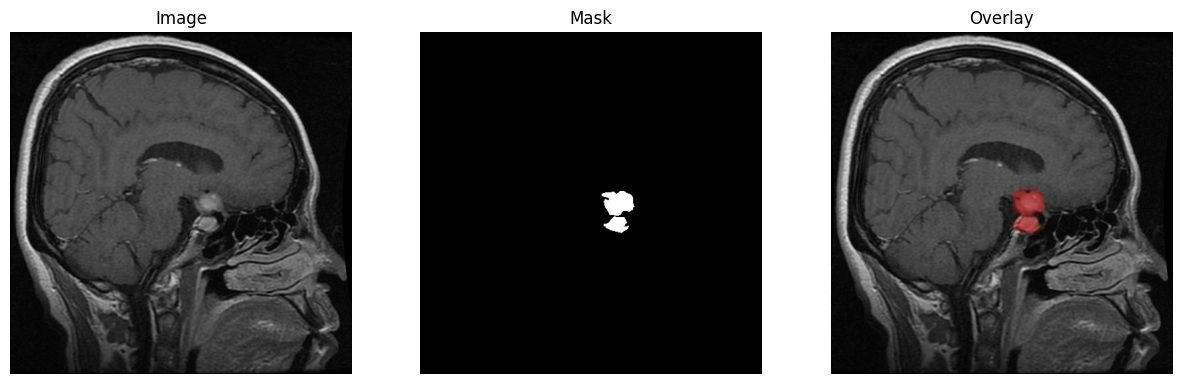

In [5]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = "/kaggle/input/brisc2025/brisc2025/segmentation_task"

img_dir = os.path.join(BASE_DIR, "train", "images")
mask_dir = os.path.join(BASE_DIR, "train", "masks")

# pick image
filename = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, filename)

# try all possible mask extensions
name_no_ext = os.path.splitext(filename)[0]

possible_ext = [".jpg", ".png", ".jpeg", ".bmp", ".tif"]

mask_path = None
for ext in possible_ext:
    candidate = os.path.join(mask_dir, name_no_ext + ext)
    if os.path.exists(candidate):
        mask_path = candidate
        break

print("Image file:", img_path)
print("Mask file:", mask_path)

if mask_path is None:
    raise FileNotFoundError("No mask found for image: " + filename)

# Load image & mask
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Overlay
overlay = img.copy()
overlay[mask > 0] = [255, 0, 0]
blended = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)

# Plot
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(mask, cmap='gray'); plt.title("Mask"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(blended); plt.title("Overlay"); plt.axis("off")
plt.show()

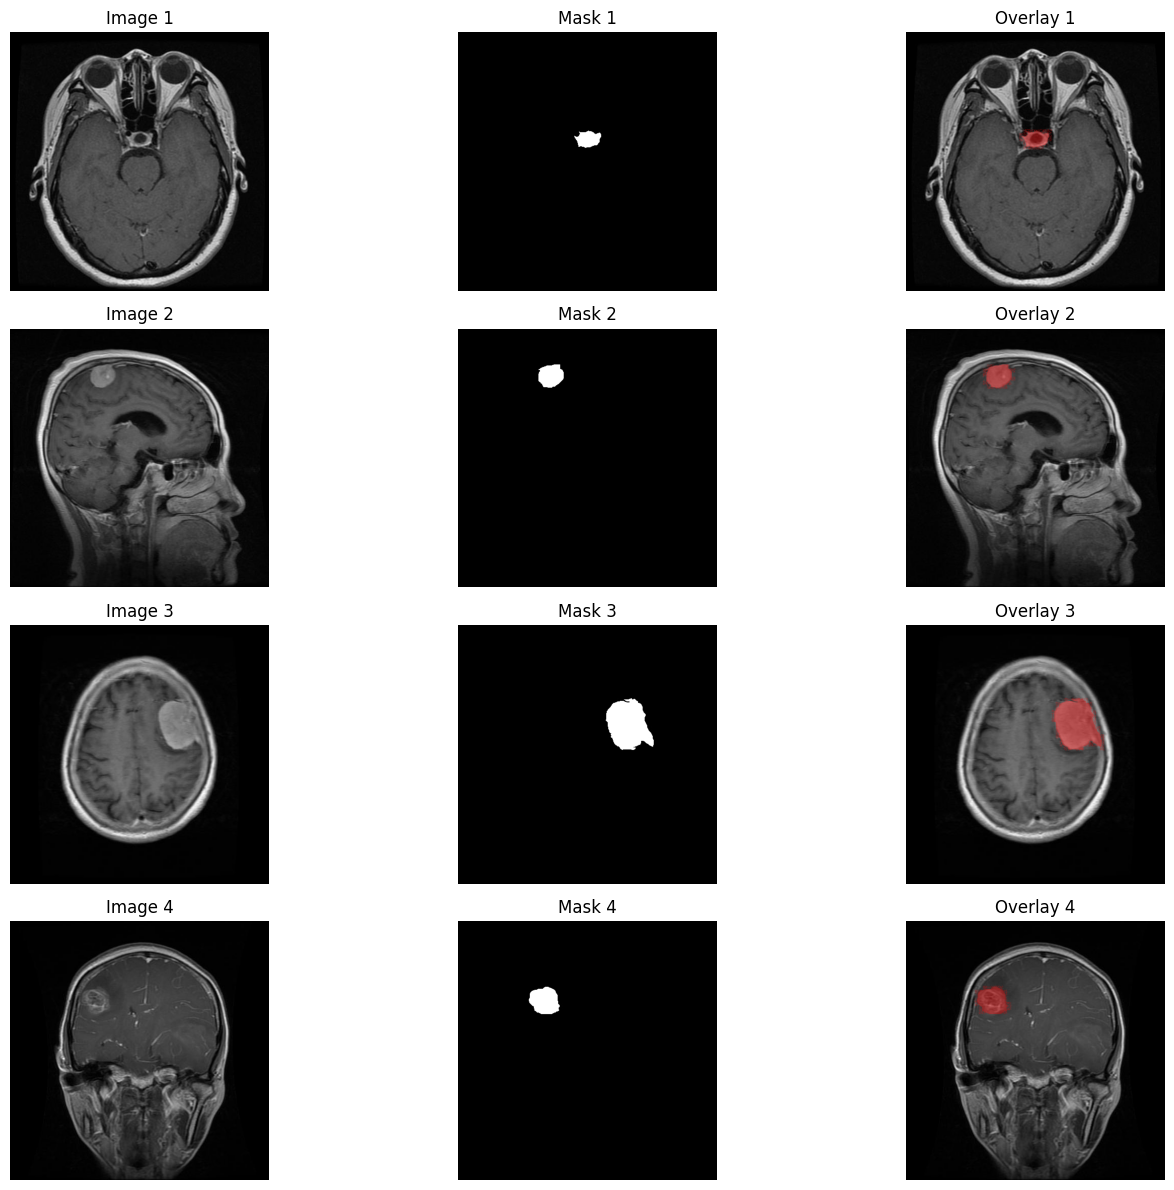

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

BASE_DIR = "/kaggle/input/brisc2025/brisc2025/segmentation_task"

img_dir = os.path.join(BASE_DIR, "train", "images")
mask_dir = os.path.join(BASE_DIR, "train", "masks")

# ---- randomly pick 4 images ----
all_images = os.listdir(img_dir)
sample_images = random.sample(all_images, 4)

possible_ext = [".jpg", ".png", ".jpeg", ".bmp", ".tif"]

plt.figure(figsize=(15, 12))

row = 1
for filename in sample_images:

    img_path = os.path.join(img_dir, filename)
    name_no_ext = os.path.splitext(filename)[0]

    # find corresponding mask
    mask_path = None
    for ext in possible_ext:
        candidate = os.path.join(mask_dir, name_no_ext + ext)
        if os.path.exists(candidate):
            mask_path = candidate
            break

    if mask_path is None:
        print("No mask found for:", filename)
        continue
    
    # load image & mask
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # overlay
    overlay = img.copy()
    overlay[mask > 0] = [255, 0, 0]
    blended = cv2.addWeighted(overlay, 0.4, img, 0.6, 0)

    # --- plot 3 columns per image ---
    plt.subplot(4, 3, (row - 1) * 3 + 1)
    plt.imshow(img)
    plt.title(f"Image {row}")
    plt.axis("off")

    plt.subplot(4, 3, (row - 1) * 3 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {row}")
    plt.axis("off")

    plt.subplot(4, 3, (row - 1) * 3 + 3)
    plt.imshow(blended)
    plt.title(f"Overlay {row}")
    plt.axis("off")

    row += 1

plt.tight_layout()
plt.show()

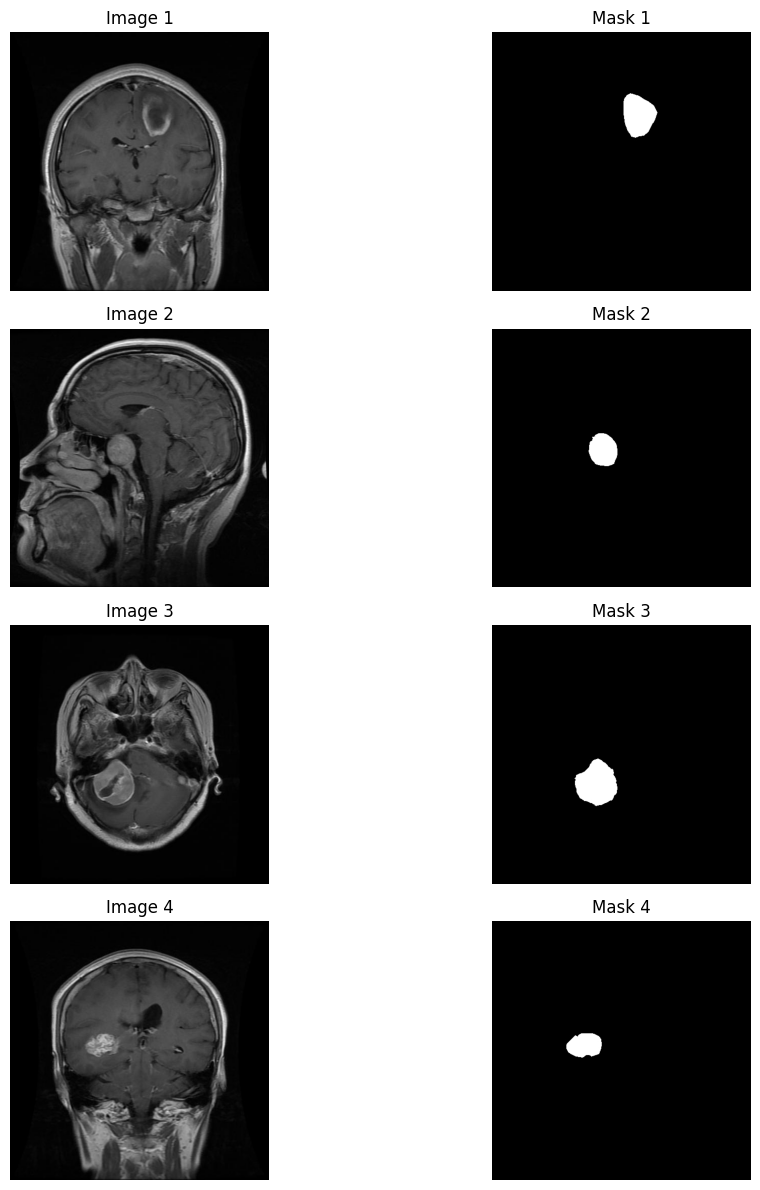

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

BASE_DIR = "/kaggle/input/brisc2025/brisc2025/segmentation_task"

img_dir = os.path.join(BASE_DIR, "train", "images")
mask_dir = os.path.join(BASE_DIR, "train", "masks")

# ---- randomly pick 4 images ----
all_images = os.listdir(img_dir)
sample_images = random.sample(all_images, 4)

possible_ext = [".jpg", ".png", ".jpeg", ".bmp", ".tif"]

plt.figure(figsize=(12, 12))

row = 1
for idx, filename in enumerate(sample_images):

    img_path = os.path.join(img_dir, filename)
    name_no_ext = os.path.splitext(filename)[0]

    # find corresponding mask
    mask_path = None
    for ext in possible_ext:
        candidate = os.path.join(mask_dir, name_no_ext + ext)
        if os.path.exists(candidate):
            mask_path = candidate
            break

    if mask_path is None:
        print("No mask found for:", filename)
        continue

    # load image & mask
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # ---- plot image ----
    plt.subplot(4, 2, idx*2 + 1)
    plt.imshow(img)
    plt.title(f"Image {idx+1}")
    plt.axis("off")

    # ---- plot mask ----
    plt.subplot(4, 2, idx*2 + 2)
    plt.imshow(mask, cmap="gray")
    plt.title(f"Mask {idx+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()